# Quantum Circuits and Quantum Algorithms

In this notebook, we will look at the basic building blocks of quantum algorithms and the universal language they are formulated in. First, if you are unfamiliar with jupyter notebooks:

* Go to the `Help` menu above and select `User Interface Tour`
* Press `H` or select `Help` -> `Keyboard Shortcuts` to see the most important keyboard shortcuts
* Read the [Jupyter Documentation](https://docs.jupyter.org/en/latest/) for more details.

You can change literally anything in this notebook, add and remove code, and also write notes in the markdown format. We recommend you make a backup copy of this file in case you need a fresh start.

Let's get started.

## Setup

First we need to import some packages. We will use _pennylane_ as the quantum computing framework. It has a very accessible and easy to understand API and comes with great documentation and lot's of examples demonstrating basic concepts in quantum computing as well as latest research in the field:

* [Documentation](https://docs.pennylane.ai/en/stable/)
* [Demos](https://pennylane.ai/qml/demonstrations/)

In [1]:
import pennylane as qml
import numpy as np

%matplotlib inline
from workshop.utils import sample_histogram

## Quantum Circuits and Quantum Gates

Before we get into quantum circuits and gates, let's quickly recap some fundamentals from the introduction session this week. 

### Quantum States and qubits

The basic computational resource on a quantum computer is a _qubit_. A qubit is a quantum mechanical system that can be observed in two distinct states, which we call $|0\rangle$ and $|1\rangle$.

We can represent those two states as _basis vectors_:

\begin{align*}
    |0\rangle &= \begin{bmatrix} 1 \\ 0 \end{bmatrix} \\
    |1\rangle &= \begin{bmatrix} 0 \\ 1 \end{bmatrix} 
\end{align*}

If we _measure_ a qubit, we will always find it in either of those two states. Before we measure a qubit, it can be in a _superposition_ of those two basis states. A superposition is a linear combination of the two basis states, given by:

\begin{equation*}
    |\psi\rangle = \alpha |0\rangle + \beta |1\rangle
\end{equation*}

(**Note:** $\alpha$ is the greek letter _alpha_, $\beta$ the greek letter _beta_ and $\psi$ the greek letter _psi_. Using these symbols in quantum mechanics and quantum computing is a common naming scheme.)

The two numbers $\alpha$ and $\beta$ are called _amplitudes_ of the quantum state. They are both [complex numbers](https://en.wikipedia.org/wiki/Complex_number), that is 

\begin{equation*}
    \alpha, \beta \in\mathbb{C}.
\end{equation*}

Furthermore, the sum of their _absolute squares_ is always $1$, i.e.:

\begin{equation*}
    |\alpha|^2 + |\beta|^2 = 1.
\end{equation*}

Measuring a qubit, is probablistic in nature. The probabilities of measuring the qubit in either of the two basis states is given by:

\begin{align*}
    P(|0\rangle) &= |\alpha|^2 \\
    P(|1\rangle) &= |\beta|^2.
\end{align*}

Note that once we measure a qubit, it _collapses_ to the state that we actually measure. There is no way to observe the amplitudes directly or to reverse the destructive effect of a measurement. 

Superposition and the probablistic outcome of oberservation are (not the only) somewhat counterintuitive aspects of quantum mechanics, and therefore quantum computing, that are very different from our everyday experience interacting with the world. They really have no equivalent in the macroscopic world we observe all our live, therefore almost all analogies will necessarily be contrived and not really helpful. Many great minds have come up with theories and interpretations of what these things actually mean, but we will not get involved with that.

For now it is the best to just take it as it is. Know though that these things have been predicted and proven in theory and confirmed experimentally many times (we will get to that a bit at the end of the notebook).

### Unitary Operations and Quantum Gates

To do anything useful with a quantum computer, we have to manipulate the state of its qubits in some controlled way, so that the measurement result are the outcomes of a useful computation (at least with high probability). For now we will only look at a single qubit, which isn't all that useful, and get to multi-qubit systems a bit later.

At the beginning of the computation, all qubits of a quantum computer are usually initialized in state $|0\rangle$. The manipulations we can perform on them are mathematically described by [Unitary Matrices](https://en.wikipedia.org/wiki/Unitary_matrix). That is, if our qubit is in some state $|\psi\rangle$ at time $t$ and we perform some operation $\hat{U}$ (note that unitary matrices are usually written with a _hat_ on top of their name) that finishes at time $t+1$, we will find the qubit in state $|\psi^\prime\rangle$ given by:

\begin{equation*}
    |\psi^\prime\rangle = \hat{U}|\psi\rangle.
\end{equation*}

In principle, every unitary operation describes a valid operation on a qubit. In practise, only a limited number of unitaries are actually available as operations on quantum hardware and in this notebook we will limit the discussion to a total of three.

#### The Pauli X operator

The first operator we are going to look at is the Pauli X operator, also refered to just as _X_ operator or sometimes bitflip operator. It's unitary matrix representation is given by:

\begin{equation*}
    \hat{X} := \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}.
\end{equation*}

If we apply the Pauli X operator to one of the two basis states of the qubit, it "flips" the qubit to the other basis state:

\begin{align*}
\hat{X}|0\rangle &= \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}\begin{bmatrix} 1 \\ 0 \end{bmatrix}
            = \begin{bmatrix} 0 \\ 1 \end{bmatrix} = |1\rangle  \\
\hat{X}|1\rangle &= \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}\begin{bmatrix} 0 \\ 1 \end{bmatrix}
            = \begin{bmatrix} 1 \\ 0 \end{bmatrix} = |0\rangle
\end{align*}

More interesting is what happens when X is applied to a state in superposition. The Pauli X operator then "flips" the amplitudes between both basis components. For a state in superposition $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ we have:

\begin{align*}
    \hat{X}|\psi\rangle &= \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}(\alpha|0\rangle + \beta|1\rangle) 
                   =\begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}\begin{bmatrix} \alpha \\ \beta \end{bmatrix} \\
                  &= \begin{bmatrix} \beta \\ \alpha \end{bmatrix}
                   = \beta|0\rangle + \alpha|1\rangle
\end{align*}

#### Quantum Circuits and Gates

Time to put this into action. Like regular classical computers you are used to working with every day, quantum computers have several layers of abstraction, that we have access to, if we want to do something with them:

* On the lowest level, qubits can be manipulated by directly controlling, e.g., microwave pulses that interact with the system. This level is very dependent on the concrete hardware implementation and usually only relevant to implement higher levels of abstraction.
* The common level of abstraction is the language of quantum circuits and gates. Quantum gates correspond to unitary operations on one or several qubits. A quantum circuit describes the consecutive execution of gates over time.
* Higher level abstractions exist and commonly build on quantum circuits for common algorithms as subroutines. Higher level programming languages, domain specific languages (DSLs), and abstractions for quantum computing are an active field of research.

We will only work with quantum circuits and quantum gates in this notebook and throughout the workshop.

**Note:** The naming _circuit_ and _gate_ in this context have historical reasons and may be a bit unfortunate as they have nothing to do with electircal circuits or boolean circuits. Think of quantum circuits more like a flow-chart of operations to be executed on one or several qubits.

We will first implement a simple circuit and then look at its visual representation. First, we need a _device_. A device in pennylane is either a quantum circuit simulator, or the implementation of an API for an actual quantum computer. We will stick to the most basic quantum circuit simulator pennylane ships with: `default.qubit`. We create the device with three paramteters:

* The name/type of device, in our case `default.qubit`
* The number of `wires` which is the number of qubits we want to simulate; for now we will simulate just one.
* The number of `shots` we want to take. Remember that measurements are probablistic, so in order to understand the results, we commonly execute the same quantum circuit many times and do statistics over the measurement results to get an expectation value. On quantum hardware, it is common to execute 5000 to 10000 shots, but 1000 will suffice for our experiments here.

In [2]:
device = qml.device("default.qubit", wires=1, shots=1000)

In pennylane, to describe a quantum circuit, we wrap it inside a function and add the decorator `@qml.qnode` which tells the framework to run this function on the provided device.

To start, we will implement a very simple circuit that simply computes:

\begin{equation*}
    \hat{X}|0\rangle = |1\rangle
\end{equation*}

This is how the function looks:

In [3]:
@qml.qnode(device)
def bitflip_circuit():
    # Apply the Pauli X gate to the first (and only) qubit
    qml.PauliX(wires=0)
    
    # Sample measurement results. Since we set the `device` to 1000 shots, 1000 samples
    # will be drawn.
    return qml.sample()

Before we execute the circuit, let's have a look at its visual representation:

(<Figure size 400x200 with 1 Axes>, <Axes:>)

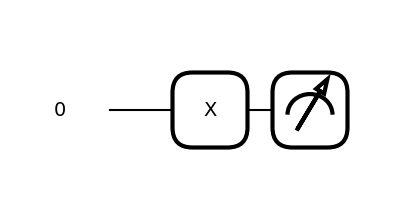

In [4]:
qml.draw_mpl(bitflip_circuit)()

The circuit is read from left to right. The first thing we see is an index for the qubit. The line going from left to right represents this qubit over the course of execution. Each of the boxes is a gate applied to the qubit. The first one being the Pauli X gate (**Note:** we use the terms _gate_, _operation_ and _unitary_ interchangeably, since they mean the same thing but in different contexts). The final box is the _measurement gate_, which represents the measurement of the qubit at the end of the computation.

Running the circuit on the simulator device is as simple as calling the function we've just defined.

In [5]:
samples = bitflip_circuit()

`samples` is now an array with all the 1000 measurement results, either $0$ for the state $|0\rangle$ or $1$ for the state $|1\rangle$. Let's check this:

In [6]:
print(f"Simulating the circuit for {device.shots} shots returned {len(samples)} samples.")

Simulating the circuit for 1000 shots returned 1000 samples.


Given the previous discussion, you can probably guess what all those 1000 samples will be? Let's have a look:

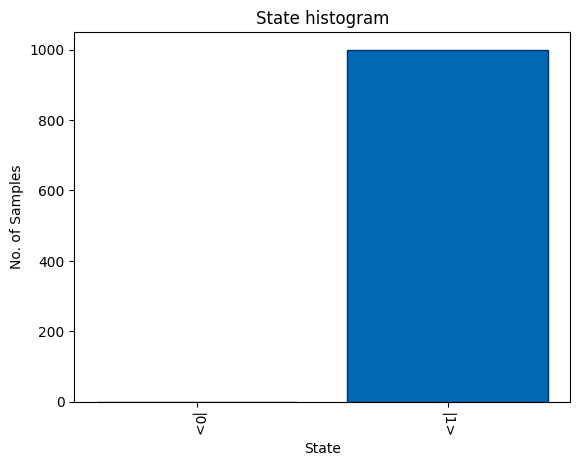

In [7]:
sample_histogram(samples)

Unsurprisingly, all mesurements returned $|1\rangle$, since applying the Pauli X gate to the $|0\rangle$ state our computation starts in just "flips" to that state. There is no probability of measuring $|0\rangle$. 

#### The Hadamard Operator

The second single-qubit gate we will need in this notebook is the _Hadamard_ operator:

\begin{equation*}
    \hat{H} := \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1\end{bmatrix}
\end{equation*}


The Hadamard operator is a major building block of almost every quantum algorithm, so it especially important to know it and understand what it does. So what does it do? It transitions a qubit from one of the basis states to a superposition with _equal_ probability of measuring either basis state afterwards. Quantum algorithms commonly operate on qubits in superposition, otherwise they wouldn't be so different from classical algorithms operating on bits.

Let's have a look of what the Hadamard operator does to the two basis states:

\begin{align*}
    \hat{H}|0\rangle &= \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) = |+\rangle \\
    \hat{H}|1\rangle &= \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle) = |-\rangle
\end{align*}

Hopefully, you can convince yourself that the two resulting states would be measured in either $|0\rangle$ or $|1\rangle$, since 

\begin{equation*}
\left|\pm \frac{1}{\sqrt{2}}\right|^2 = \frac{1}{2}.
\end{equation*}

The two states $|+\rangle$ and $|-\rangle$ are referred to as _Hadamard Basis_ of the qubit.

Time to try the Hadamard gate. We essentially just replace the `PauliX` gate in our previous circuit with a `Hadamard` gate:

In [8]:
@qml.qnode(device)
def hadamard_circuit():
    qml.Hadamard(wires=0)
    
    return qml.sample()

Let's have a look at the actual circuit:

(<Figure size 400x200 with 1 Axes>, <Axes:>)

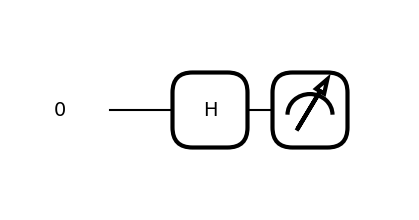

In [9]:
qml.draw_mpl(hadamard_circuit)()

And execute it on the simulator:

In [10]:
samples = hadamard_circuit()

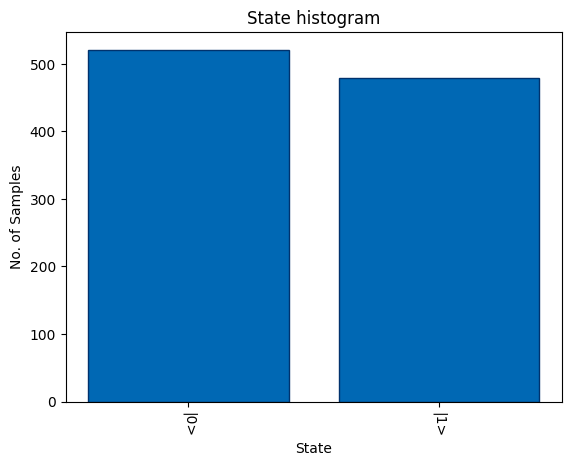

In [11]:
sample_histogram(samples)

As expected, we get roughly $500$ samples of each of the two basis states. The larger the number the of samples we draw, the more accurately it will result in a 50/50 split. The less samples we draw, the more biased the distribution might get.

#### Exercises

Now it's finally time to put what you have learned so far into action. Try the following exercises:

* Create a quantum circuit that applies two _Hadamard_ gates after each other to a single qubit. Execute the circuit and visualize the measurement samples as above. What do you notice?
* Create a circuit, that first puts the qubit into the state $|1\rangle$ and then applies a single _Hadamard_ gate. How is the state produced by this circuit different compared to the `hadamard_circuit` above? Are the measurement results different?

You can reuse the `device` we've created above or create a new one if you like.

<h3><font color="blue">Solution</font></h3>

**First part:**

In [12]:
@qml.qnode(device)
def double_hadamard_circuit():
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=0)
    
    return qml.sample()

In [13]:
samples = double_hadamard_circuit()

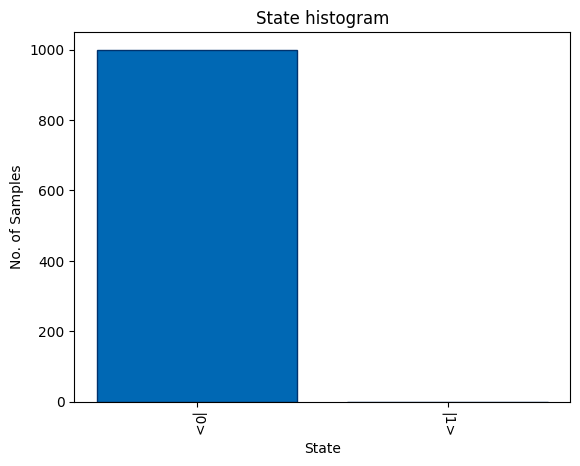

In [14]:
sample_histogram(samples)

The circuit produces the state 

\begin{equation*}
    |\psi\rangle = \hat{H}\hat{H}|0\rangle = |0\rangle
\end{equation*}

The _Hadamard_ operator is its own inverse, so if applied twice, the second application reverses the effect of the first, that is:

\begin{equation*}
    \hat{H} = \hat{H}^\dagger
\end{equation*}

**Second Part:**

In [15]:
@qml.qnode(device)
def x_hadamard_circuit():
    qml.PauliX(wires=0)
    qml.Hadamard(wires=0)
    
    return qml.sample()

In [16]:
samples = x_hadamard_circuit()

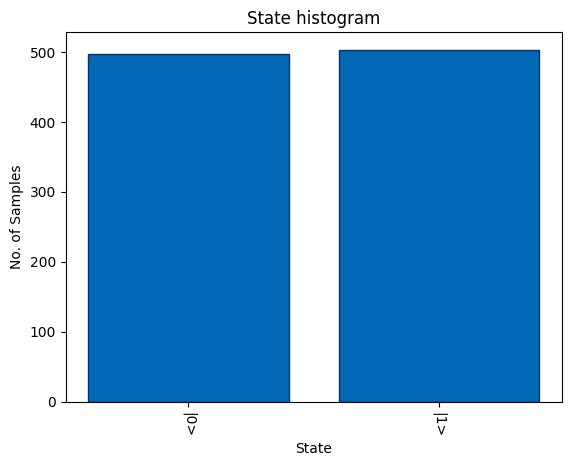

In [17]:
sample_histogram(samples)

The circuit produces the state:

\begin{equation*}
    \hat{H}\hat{X}|0\rangle = \hat{H}|1\rangle = \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle) = |-\rangle
\end{equation*}

Although the state is different from $|+\rangle$, the probability of measuring either basis state is still exactly $\frac{1}{2}$. 

## Multi-qubit systems and Entanglement

Working with a single qubit might be fun and interesting but before we can do anything useful, we need to have a look at systems with more than one qubit.

### Multi-qubit systems

Again, first a quick recap of what you've learned in the introduction session of this workshop. A two qubit system has **four** basis states $|00\rangle$, $|01\rangle$, $|10\rangle$ and $|11\rangle$. The entire system is described by **four** complex valued amplitudes:

\begin{equation*}
    |\psi\rangle = \alpha_{00}|00\rangle + \alpha_{01}|01\rangle + \alpha_{10}|10\rangle + \alpha_{11}|11\rangle
\end{equation*}

Similar to a single qubit, we can write the two qubit system $|\psi\rangle$ as column vector as such:

\begin{equation*}
    |\psi\rangle = \begin{bmatrix} \alpha_{00} \\ \alpha_{01} \\ \alpha_{10} \\ \alpha_{11} \end{bmatrix}.
\end{equation*}

In general, an $n$ qubit system is represented by $2^n$ complex amplitudes, so the representation in form of column vectors would get _really_ impractical eventually to write down, which is one of the reasons the _Dirac_ notation in form of _kets_ is useful. Often, the basis states of a multi-qubit system are not written as bit-strings, but just numbered as $|0\rangle, |1\rangle, |2\rangle, \ldots, |2^n-1\rangle$ if it is clear from context, what is meant.

### Measurment of Multi-qubit systems

For the measurement, basically the same rules as for a single qubit apply. A two qubit system can be measured in either of the four basis states with probabilities:

\begin{align*}
    p(|00\rangle &= |\alpha_{00}|^2 \\
    p(|01\rangle &= |\alpha_{01}|^2 \\
    p(|10\rangle &= |\alpha_{10}|^2 \\
    p(|11\rangle &= |\alpha_{11}|^2 
\end{align*}

Consequently it always holds that

\begin{equation*}
    |\alpha_{00}|^2  + |\alpha_{01}|^2  + |\alpha_{10}|^2  + |\alpha_{11}|^2  = 1
\end{equation*}

**Note**: We can measure individual qubits of a multi-qubit system, some of them, or all of them.

#### Exercise

* For a two qubit system $|\psi\rangle$ as outlined above, what is the probability of measuring the first qubit in state $|1\rangle$?

<h3><font color="blue">Solution</font></h3>

The probability of measuring a selected qubit in state $|1\rangle$ is the sum of all probabilities for states in which it has this state in the complete system.

The combined state of two qubits:

\begin{align*}
    |a\rangle &= \begin{bmatrix} a_0 \\ a_1 \end{bmatrix} \\
    |b\rangle &= \begin{bmatrix} b_0 \\ b_1 \end{bmatrix} 
\end{align*}

is composed by applying the _tensor product_:

\begin{equation*}
    |ba\rangle = 
    |b\rangle|a\rangle =
    |b\rangle \otimes |a\rangle =
    \begin{bmatrix}
        b_0\begin{bmatrix} a_0 \\ a_1 \end{bmatrix} \\
        b_1\begin{bmatrix} a_0 \\ a_1 \end{bmatrix}
    \end{bmatrix}
    = 
    \begin{bmatrix}
        b_0a_0 \\ b_0a_1 \\ b_1a_0 \\ b_1a_1
    \end{bmatrix}
\end{equation*}

### The CNOT Gate

Before we get to _entanglement_ and how to actually create it, we have a look at one of the most common and widely used two-qubit gates, the $CNOT$ gate. $CNOT$ is short for _Controlled Not_, which describes its action on two qubits in basis states. First the unitary matrix for the gate:

\begin{equation*}
    CNOT := \begin{bmatrix}
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 \\
        0 & 0 & 1 & 0
    \end{bmatrix}
\end{equation*}

In the standard basis, that is with qubits in either state $|0\rangle$ or $|1\rangle$, the first qubit the $CNOT$ gate acts on is called _control_ whereas the second is called _target_. The effect in the standard basis is best shown with a table, similar to a _truth table_ for classical logic operators:

|Before     |           |              |After      |            |
|:----------|:----------|:------------:|:----------|:-----------|
|**Control**|**Target** |              |**Control**|**Target**  |
|$|0\rangle$|$|0\rangle$|$\Rightarrow$ |$|0\rangle$|$|0\rangle$ |
|$|0\rangle$|$|1\rangle$|$\Rightarrow$ |$|0\rangle$|$|1\rangle$ |
|$|1\rangle$|$|0\rangle$|$\Rightarrow$ |$|1\rangle$|$|1\rangle$ |
|$|1\rangle$|$|1\rangle$|$\Rightarrow$ |$|1\rangle$|$|0\rangle$ |

#### Exercise

Confirm the results from the table above. For this:

* Create a new `"default.qubit"` device, but this time with two wires and some number of shots e.g., `1000`
* Implement either one or multiple circuits to produce the results from the table.
* Visualize the results.

**Note 1:** The function that implements the circuit is basically a normal python function. You can give it parameters and have things like `if` statements or `for` loops inside it.

**Note 2:** The $CNOT$ gate is available in pennylane as `qml.CNOT`, you can find the documentation [here](https://docs.pennylane.ai/en/stable/code/api/pennylane.CNOT.html).


<h3><font color="blue">Solution</font></h3>

In [18]:
device = qml.device("default.qubit", wires=2, shots=1000)

In [19]:
@qml.qnode(device)
def test_cnot_circuit(inits: str):
    for idx, init in enumerate(inits):
        if init == '1':
            qml.PauliX(wires=idx)
        
    qml.CNOT(wires=[0, 1])
    
    return qml.sample()

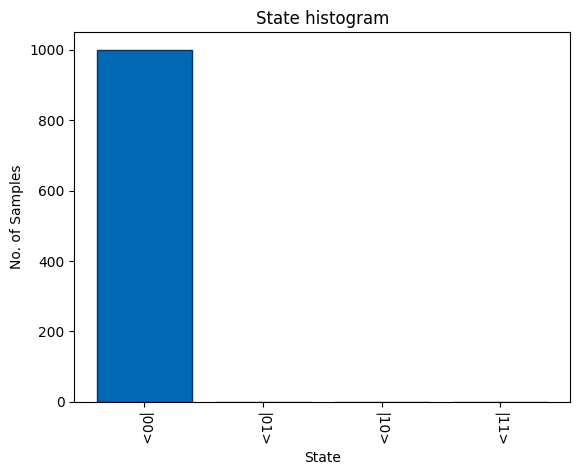

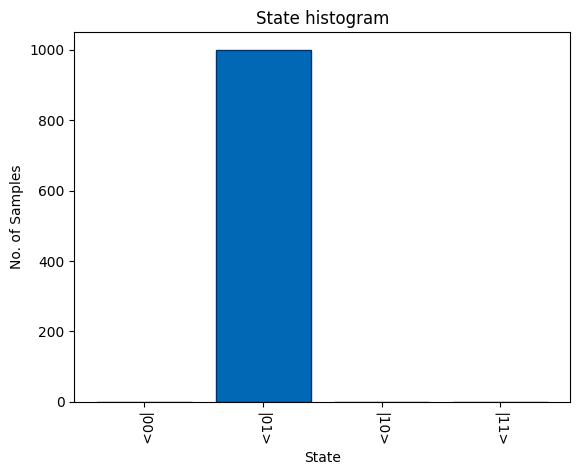

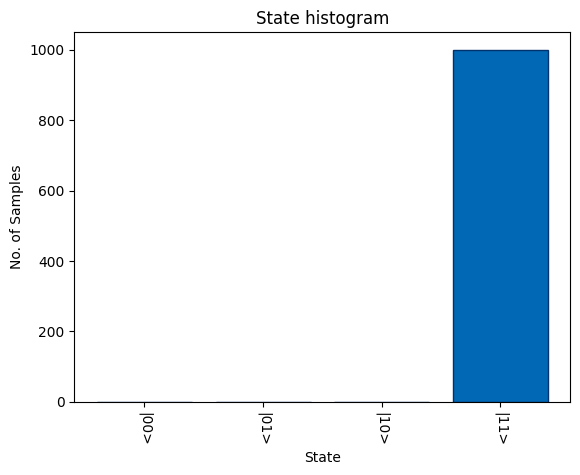

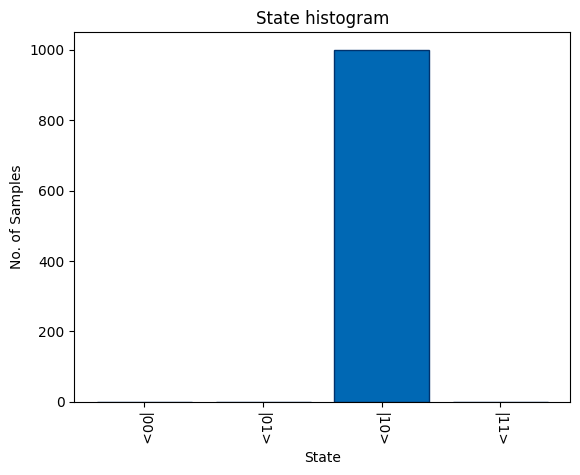

In [20]:
for init in ['00', '01', '10', '11']:
    samples = test_cnot_circuit(init)
    sample_histogram(samples)

### Entanglement

Using a $CNOT$ gate on qubits in the standard basis isn't all that interesting. More interesting things happen if we first put one or both qubits into superposition. To see this in action, we will do the following:

* Start with two qubits in state $|00\rangle$
* Apply the _Hadamard_ gate to the first qubit, putting it into an equal superposition 
* Apply the _CNOT_ gate to both qubits
* Measure both qubits

First we need a device with two qubits.

In [21]:
device = qml.device("default.qubit", wires=2, shots=1000)

Then the circuit, which should look somewhat familiar by now:

In [22]:
@qml.qnode(device)
def bell_circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    
    return qml.sample()

Let's see how it looks, before we run it:

(<Figure size 500x300 with 1 Axes>, <Axes:>)

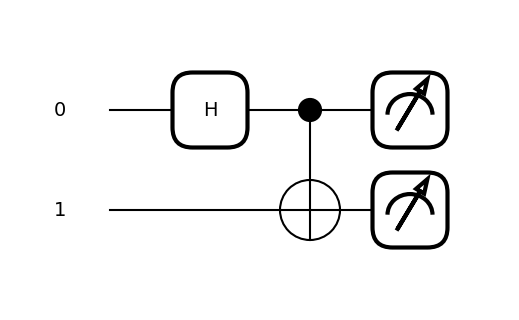

In [23]:
qml.draw_mpl(bell_circuit)()

The _CNOT_ gate is the one spanning over both qubits. The black dot on top marks the _control_, the circle with the plus inside is the _target_. Let's run it:

In [24]:
samples = bell_circuit()

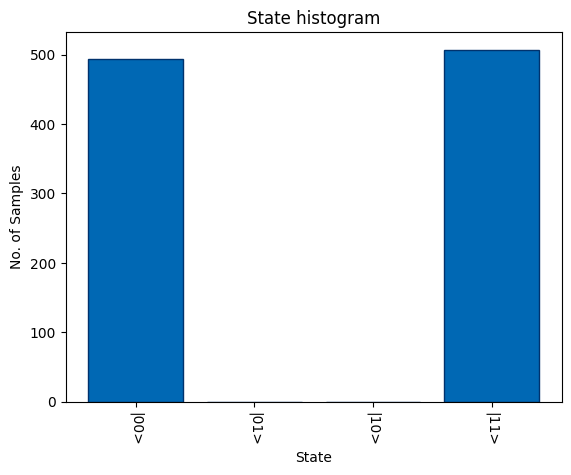

In [25]:
sample_histogram(samples)

The measurements are (roughly) half $|00\rangle$ and $|11\rangle$. The other two states were never observed. To understand the effect at work here, let us examine the state created by the circuit, which is (feel free to do the math to confirm this):

\begin{equation*}
    |\Phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)
\end{equation*}

Given that the amplitude for $|00\rangle$ and $|11\rangle$ is $\frac{1}{\sqrt{2}}$ for both and $0$ for the other two basis states $|01\rangle$ and $|10\rangle$, we have a probability of exactly 50% of observing either of the first two and 0% for the other two.

This state $|\Phi^+\rangle$ is one of the four **Bell States**, which are a group of _entangled_ states that play an important role in some fundamental discoveries in quantum mechanics (we will get to that in a moment) and that are also a building block and resource in many algorithms and protocols in quantum computing and quantum information.

This type of state has two interesting properties:

* It cannot be formulated as a tensor product of two individual qubits
* Imagine you would give each of the qubits to one of two persons, say, Alice and Bob, and would separate them by a very large distance. Assume Alice now measures her qubit. With a probability of 50% she measures $|0\rangle$ and with probability 50% $|1\rangle$. Say she measured $|1\rangle$. What do you think Bob will observe, if he measures his qubit now? He will _always_ measure the same state as Alice, no matter how often the experiment is repeated, the measurement results are _perfectly correlated_.

No such thing exists outside of quantum mechanics. The theory predicting correlations created by quantum entanglement, that go beyond what is possible classically, had been first formulated by John S. Bell in 1964 and experimentally confirmed over the following deacades, leading to the Nobel price in physics for Alain Aspect, John Clauser and Anton Zeilinger in 2022. The actual experiment is a bit more involved than the setting described above, but still pretty simple. Since this whole topic is outside of the scope of this workshop, you can learn more about the history, experiment, results, and how to actually implement this in a great video by the IBM Qiskit team, which you can find [here](https://www.youtube.com/watch?v=9OM0jSTeeBg).

#### Exercise

A generalization of Bell states are the Greenberger-Horne-Zeilinger (GHZ) states for $n>2$ qubits. They have the form:

\begin{equation*}
    |GHZ\rangle = \frac{1}{\sqrt{2}}(|00\ldots 0\rangle + |11\ldots 1\rangle).
\end{equation*}

Use what you've learned so far and try to implement a circuit that creates a _four qubit_ GHZ state. There is are two tips below, in case you struggle with the implementation.


<details>
    <summary><b>Click here for the tips</b></summary>
    <ul>
        <li>You need to create a new device with four wires.</li>
        <li>You need a total of four gates. One <i>Hadamard gate</i> and three <i>CNOT gates</i></li>
    </ul>
</details>

<h3><font color="blue">Solution</font></h3>

In [26]:
device = qml.device("default.qubit", wires=4, shots=1000)

In [27]:
@qml.qnode(device)
def ghz_circuit():
    qml.Hadamard(wires=0)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    
    return qml.sample()

(<Figure size 700x500 with 1 Axes>, <Axes:>)

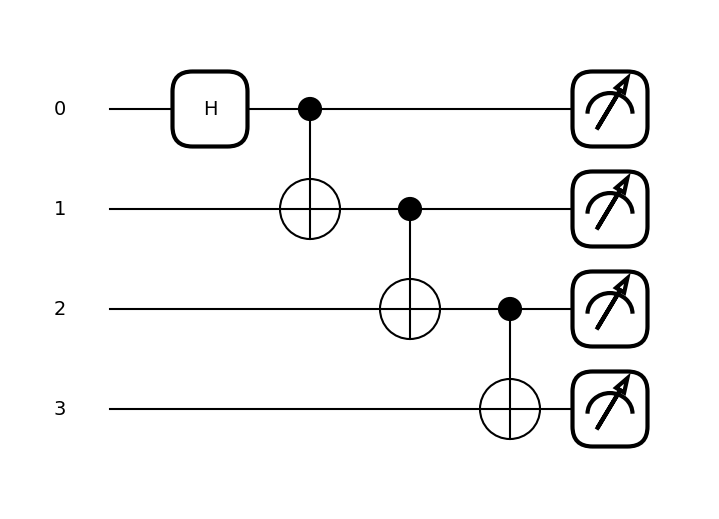

In [28]:
qml.draw_mpl(ghz_circuit)()

In [29]:
samples = ghz_circuit()

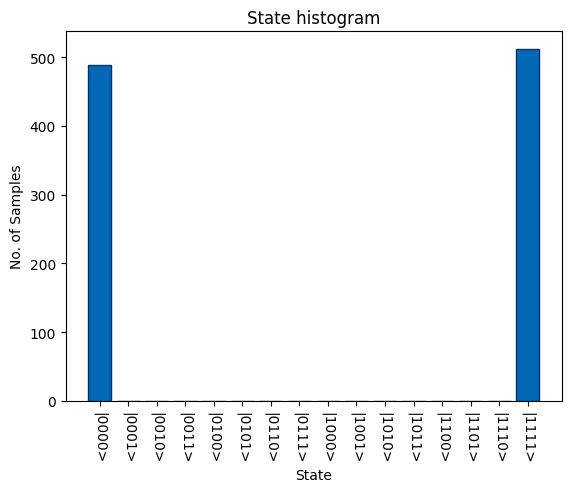

In [30]:
sample_histogram(samples)

## Simon's Algorithm

Simon's algorithm was one of the first few algorithms that demonstrated an advantage of quantum computers over classical computers. The algorithm was discovered and described in what still can be considered the very early days of quantum computing by Daniel R. Simon in 1997 [1]. The problem it solves, which we will get to momentarily, may seem very artificial at first glance, but it is in fact a version of finding the period of a function. Conceptually it informed Shor's algorithm [2], which efficiently solves factoring and the discrete logarithm problem on a quantum computer - many common asymmetric cryptography we use today relies on these problems being hard to solve (Don't worry though, current quantum computers aren't nearly large enough to break keys of common lengths and by the time they are, we will have quantum hard cryptography as default).

Before we dive in, if you want to learn a bit about the history of early quantum computing, Simon's problem, Shor's algorithm and more, [here](https://www.youtube.com/watch?v=6qD9XElTpCE) is a great video with Peter Shor telling the story from his perspective.

### The Problem

The problem we are trying to solve is the following: We are given a function $f$ that takes as input a bit-string of length $n$ and returns a bit-string of length $n$. We furthermore know that the function will have either of the following properties:

* $f$ is **one-to-one**, that is, for _every_ two possible inputs $x$ and $y$ we have $f(x) \neq f(y)$
* $f$ is **two-to-one**, that is, for _every_ possible input $x$, there is _exactly one_ other possible input $y\neq x$, such that $f(x) = f(y)$. 

In case we have $f(x)=f(y)$ for two inputs $x$ and $y$ and hence a two-to-one function $f$, there is a single unique _secret_ bit-string $s$, such that

\begin{equation*}
    x\oplus y = s.
\end{equation*}

$\oplus$ is the bitwise exclusive-or (XOR), you may know from classical logic circuits. For each bit on both operands, the corresponding bit in the result is set to $1$ if and only if both input bits are different, otherwise it is set to $0$. For example:

\begin{align*}
        &\quad 01101001 \\
 \oplus &\quad 10111100 \\
 \hline
   =     &\quad 11010101
\end{align*}

In case $f$ is a one-to-one function, $s=000\ldots$. Now here is the problem: Given such a function $f$ as **black-box** or **oracle**, meaning we know nothing of its internals and may only call it as often as we need with any input, how fast can we determine if $f$ is one-to-one or two-to-one? This problem is indeed equivalent to finding the secret bit-string $s$.

### The Classical Solution

Solving this problem classically is quite straightforward:

* Call $f$ with half of the possible inputs and then one more.
* If all return values of $f$ were different, we know the function is one-to-one and $s=000\ldots$.
* If the function is two-to-one, we _must_ have found at least one pair of possible inputs $x,y$ that produce an equal return value. In that case we can compute $s=x\oplus y$.

Given that there are $2^n$ possible bit-strings of length $n$, we therefore have to call $f$ in the worst-case $2^{n-1}+1$ times. This is always the case for a one-to-one function, for a two-to-one function we might find a pair with equal return value earlier, but there is no guarantee for that.

There are some clever improvements for this procedure, which are beyond the scope of this workshop, but in general the _complexity_ to solve this problem is _exponential_ in $n$, the lengths of the input to $f$.

### Quantum Oracles

In order to formulate a quantum circuit to solve this problem, we have to implement the black-box function $f$ as a unitary operation. Before we can do that, it is helpful to introduce the term _quantum register_. A quantum register is simply a collection of a number of qubits, that we _logical_ group together when describing an algorithm, as they serve a common purpose. So for all the circuits we have looked at so far, we simply had a single quantum register of qubits.

In order to implement $f$ on a quantum computer, we need two registers. Assume $f$ takes as input a bit-string of length $n$. We express $f$ as unitary, such that it performs the following transformation:

\begin{equation*}
    |x\rangle|a\rangle = |x\rangle|a\oplus f(x)\rangle.
\end{equation*}

$|x\rangle$ is the input register of $n$ qubits and $|a\rangle$ the _ancilla_ register, also with $n$ qubits. For the following discussion $|a\rangle$ will always start in the intial state $|0\rangle^{\otimes n} = |0\rangle \otimes |0\rangle \otimes \cdots \otimes |0\rangle$, so we can simplify this to:

\begin{equation*}
    |x\rangle|0\rangle^{\otimes n} = |x\rangle|f(x)\rangle.
\end{equation*}

Let's make an example. Let's assume we have a function $f_1$, that takes a bit-string of length $2$ as input and returns a bit-string of the same length. Since we only have four possible inputs, we can describe the function as a table:

|$x$  |$f_1(x)$|
|:---:|:-----:|
|$00$ |$10$   |
|$01$ |$01$   |
|$10$ |$10$   |
|$11$ |$01$   |

For our specific problem (finding $s$), it suffices to create an unitary oracle, that exhibits the same secret bit-string as our function. For $f_1$ that is $s = 10$, since

\begin{align*}
    00 \oplus 10 &= 10 \\
    01 \oplus 11 &= 10
\end{align*}

The procedure for creating such an oracle for Simon's algorithm is fortunately pretty simple:

1. Create a CNOT gate from each input qubit to the corresponding ancilla qubit
2. Find the index $i$ of the first non-zero bit in $s$
3. Create a CNOT gate from the input qubit $i$ to each ancilla qubit $j$, where $s_j = 1$.

For simplicity, we will read bit-string from right to left to save some extra code later. The results will be exactly the same, as long as you stick to one convention.

Let's implement the oracle. First a device with four qubits, since our input has length $n=2$.

In [31]:
device = qml.device("default.qubit", wires=4, shots=1000)

The oracle as function, that we can use inside any circuit:

In [32]:
def f1_oracle():
    # Step 1 of the procedure described above:
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[1, 3])
    
    # The only bit in s=10 that is `1` has index 0. So we need one extra CNOT from
    # the first input qubit to the first ancilla qubit
    qml.CNOT(wires=[0, 2])

In order to draw it, we need a "scratch" circuit with a device and measurements:

In [33]:
@qml.qnode(device)
def scratch_circuit():
    f1_oracle()
    return qml.sample(wires=[0,1,2,3])

(<Figure size 600x500 with 1 Axes>, <Axes:>)

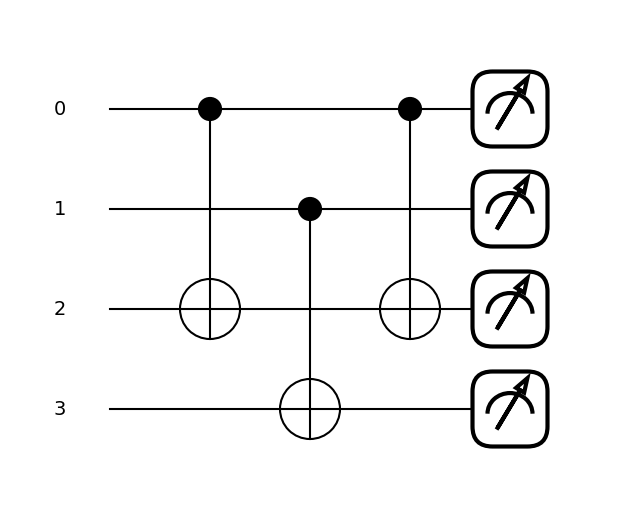

In [34]:
qml.draw_mpl(scratch_circuit)()

#### Exercise

Implement a quantum circuit, that takes a bit-string such as `'10'` as input and evaluates the oracle implemented above. Test the circuit for all four possible inputs and observe the results. Convince yourself, that the computed function has the same periodicity and "secret" $s$ as $f_1$.

<h3><font color="blue">Solution</font></h3>

In [35]:
@qml.qnode(device)
def test_f1_oracle(inits: str):
    for idx, init in enumerate(inits):
        if init == '1':
            qml.PauliX(wires=idx)
        
    f1_oracle()
    
    return qml.sample()

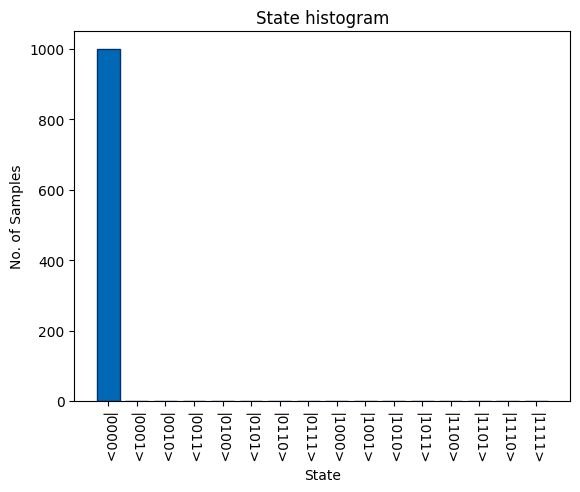

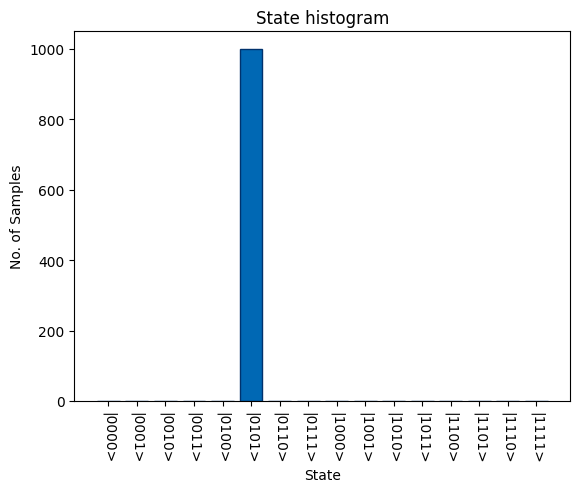

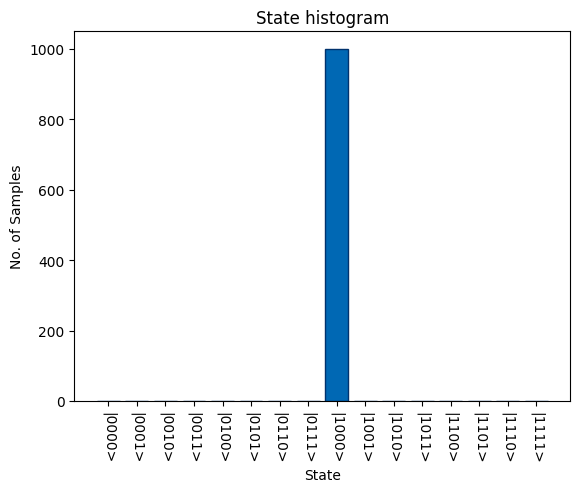

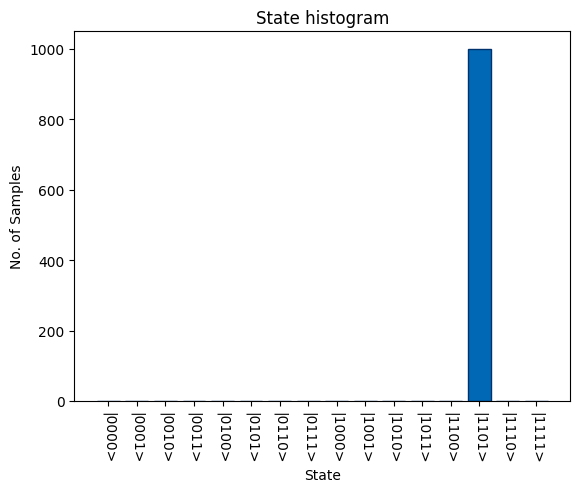

In [36]:
for init in ['00', '01', '10', '11']:
    samples = test_f1_oracle(init)
    sample_histogram(samples)

We find:

|$x$  |$O_{f_1}(x)$|
|:---:|:-----:|
|$00$ |$00$   |
|$01$ |$01$   |
|$10$ |$00$   |
|$11$ |$01$   |

And

\begin{equation*}
    s = 00 \oplus 10 = 01 \oplus 11 = 10
\end{equation*}

which is the same as for $f_1$.

### Simon's Algorithm

Given an oracle such as the one described above, Simon's algorithm to find $s$ does the following:

1. Put all input qubits into superposition by applying a Hadamard gate to them.
2. Apply the oracle to the input and ancilla qubits.
3. Apply Hadamard gates to all input qubits.
4. Measure the **input** qubits.

The result for a single shot of this execution will be a bit-string $z$ that has properties that will help us to derive $s$ later. Let's go through these steps one by one and see what happens, before we get to that.

#### Step 0:

Before we start, all $2*n$ qubits of the the input and ancilla register will be in state $|0\rangle$, so we have:

\begin{equation*}
    |\psi_0\rangle = |0\rangle^{\otimes n}|0\rangle^{\otimes n}.
\end{equation*}

#### Step 1:

We apply a Hadamard gate to each of the input qubits. We therefore create a superposition of all possible $2^n$ basis states in the input register, with an amplitude of $\frac{1}{\sqrt{2^n}}$ for each:

\begin{equation*}
    |\text{input}\rangle = \frac{1}{\sqrt{2^n}} (|00\ldots 00\rangle + |00\ldots 01\rangle + \cdots 
                           + |11\ldots 11\rangle).
\end{equation*}

We can write this very compactly together with the ancilla register as:

\begin{align*}
    |\psi_1\rangle &= \hat{H}^{\otimes n}|0\rangle^{\otimes n}|0\rangle^{\otimes n} \\
                   &= \frac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n}|x\rangle|0\rangle^{\otimes n}.
\end{align*}

#### Step 2:

Now we apply the oracle $f$ to all qubits. The oracle leaves the input register unchanged and computes the value of $f$ on the state in the input register:

\begin{equation*}
    |\psi_2\rangle = \frac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n}|x\rangle|f(x)\rangle.
\end{equation*}

Let's discuss, what we have achieved here. If you look at the state $|\psi_2\rangle$ you'll find, that it is a superposition over all possible basis states, where any possible input $x$ is in the input register and the corresponding function value $f(x)$ is in the ancilla register. 

**Most important of all notes:** Computations such as the one above regularly lead to the **false** claim, that quantum computers work by "Computing each possible output at once" or similar. In fact, the superposition above contains each input-output combination of $f$, but what was to happen if we were to measure all qubits in this state? We would get _exactly_ one random input $x$ and its corresponding output value $f(x)$ with equal probability for all $2^n$ possible $x$. So running the circuit once, gives you exactly one (random) result. If you wanted all of them, you would have to run the circuit _at least_ $2^n$ times. Which is exactly what you had to do on a classical computer.

Keep that in mind and let's move on.

#### Step 3:

If we were to measure the ancilla register now, we'd get any value $f(x)$ with equal probability. After that, the state of the input register would be:

\begin{equation*}
    |\phi\rangle = \frac{1}{\sqrt{2}}(|x\rangle + |y\rangle).
\end{equation*}

Where in case of a on-to-one function $f$ we'd have $x=y$ and in case of a two-to-one function it holds $f(x)=f(y)$ and hence:

\begin{equation*}
    x = y \oplus s.
\end{equation*}

We will not measure the ancilla register, since we don't care about some $f(x)$ and continue the discussion from $|\phi\rangle$ in the input register.

As last step before the measurement, we apply a Hadamard gate to each qubit of $\phi$ which leads to the state:

\begin{equation*}
    |\psi_3 = \frac{1}{\sqrt{2^n+1}}\sum_{z\in\{0,1\}^n}(a+b)|z\rangle
\end{equation*}

with

\begin{align*}
    a &= (-1)^{x\cdot z} \\
    b &= (-1)^{y\cdot z}.
\end{align*}

The term $x\cdot z$ means the inner product of the bit-strings $x$ and $z$ here. In state $|\psi_3\rangle$ only basis states $|z\rangle$ have an amplitude that is non-zero, if $a=b$, since $a$ and $b$ can only take values $-1$ and $1$, consequently we have for every possible measurement results:

\begin{align*}
    a &= b \\
    (-1)^{x\cdot z} &= (-1)^{y\cdot z} \\
    x\cdot z &= y\cdot z \\
    (y\oplus s) \cdot z &= y\cdot z \\
    y\cdot z \oplus s\cdot z &= y\cdot z \\
    s\cdot z &= 0.
\end{align*}

#### Step 4:

Time to measure the input register. We know that the state $|z\rangle$ we find the qubits in, corresponds to a bit-string for which:

\begin{equation*}
    s\cdot z = 0.
\end{equation*}

So how do we get $s$ from this? We run the circuit multiple times, till we have $n$ different bit-strings $z_i$, such that we can classically solve the system of linear equations:

\begin{align*}
    s\cdot z_1 &= 0 \\
    s\cdot z_2 &= 0 \\
               &\vdots \\
    s\cdot z_n &= 0 
\end{align*}

This always has the trivial solution $s=00\ldots 0$ and if this is the only solution, we know $f$ is one-to-one. If it has another solution $s\neq 00\ldots 0$, then $f$ is two-to-one and we have our secret $s$.

### Complexity

As we observed earlier, the classical solution to finding $s$ scales exponential in the lengths of the input to $f$. How does the quantum algorithm do?

* We need to run the circuit at least $n$ times to get $n$ different $z_i$, likely a bit more often, but in general this will grow _linearly_ in $n$.
* Solving the system of linear equation afterwards, can be done in polynomial time on a classical computer, the complexity grows with approximately $n^3$.

So in total, the quantum algorithm with classical post-processing is of polynomial complexity, whereas the classical algorithm is of exponential complexity!

### Implementation

The implementation for the oracle created above, should now be fairly straightforward. First we need a device with $4$ qubits. The tricky part is to decide on the number of shots, for $n=2$ chances are relatively high to get the same output multiple times in a row. We go with $4$ shots here, if that doesn't suffice, we simply run the circuit again.

In [37]:
device = qml.device("default.qubit", wires=4, shots=4)

Implementation of the circuit, note that we only measure the input register.

In [38]:
@qml.qnode(device)
def simon_f1():
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    
    f1_oracle()
    
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    
    return qml.sample(wires=[0, 1])

(<Figure size 800x500 with 1 Axes>, <Axes:>)

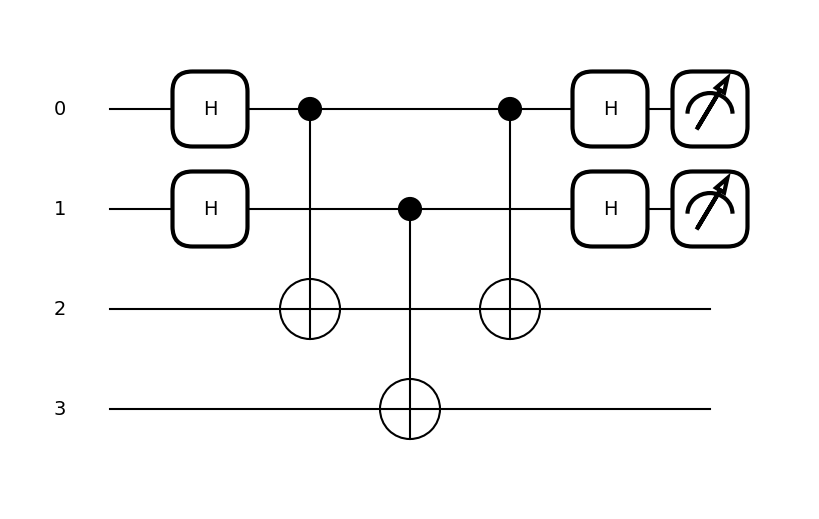

In [39]:
qml.draw_mpl(simon_f1)()

We now run the circuit for $4$ shots and filter out all duplicate results:

In [40]:
samples = simon_f1()
zs = np.unique(samples, axis=0)

Let's check if we have enough samples to proceed, if not, simply run the previous cell again:

In [41]:
if zs.shape[0] < 2:
    print("Not enough samples, run again!")
else:
    print("We got enough samples, proceed.")

We got enough samples, proceed.


we take the first two samples and have a look at the corresponding bitstrings:

In [42]:
for idx, z in enumerate(zs[:2]):
    bitstring = ''.join(z.astype(int).astype(str))
    
    print(f"z_{idx+1} = {bitstring}")

z_1 = 00
z_2 = 01


Using these two $z_i$, we can write the system of linear equations:

\begin{align*}
    s\cdot 00 &= 0 \\
    s\cdot 01 &= 0.
\end{align*}

If we expand the inner product, we get for our secret $s=s_1s_2$:

\begin{align*}
    0\cdot s_1 + 0\cdot s_2 &= 0 \\
    0\cdot s_1 + 1\cdot s_2 &= 0.
\end{align*}

This has obviously the trivial solution $s_1=s_2=0$ but also $s_1=1$ and $s_2=0$. Therefore we confirmed our function is two-to-one and $s=10$.

#### Exercise

Given the following function $g$ on bit-strings of lengths $n$:

|$x$   |$g(x)$ |
|:----:|:-----:|
|$000$ |$001$  |
|$001$ |$111$  |
|$010$ |$000$  |
|$011$ |$100$  |
|$100$ |$111$  |
|$101$ |$001$  |
|$110$ |$100$  |
|$111$ |$000$  |

* Compute $s$ for $g$.
* Implement the oracle for $s$.
* Validate your oracle.
* Implement Simon's algorithm for $g$.
* Run the circuit a sufficient number of times to retrieve enough $z_i$.
* Solve the resulting system of linear equations and see if you find the same $s$ you started with.

<h3><font color="blue">Solution</font></h3>

First the secret $s$:

\begin{align*}
    s &= 000 \oplus 101 \\
      &= 001 \oplus 100 \\
      &= 010 \oplus 111 \\
      &= 011 \oplus 110 = 101
\end{align*}

Second, we implement and validate the oracle. For the validation we will create a single-shot device, to see the effect of each basis state:

In [43]:
device = qml.device("default.qubit", wires=6, shots=1)

In [44]:
def g_oracle():
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[1, 4])
    qml.CNOT(wires=[2, 5])
    
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[0, 5])

In [45]:
@qml.qnode(device)
def scratch_circuit():
    g_oracle()
    return qml.sample()

(<Figure size 800x700 with 1 Axes>, <Axes:>)

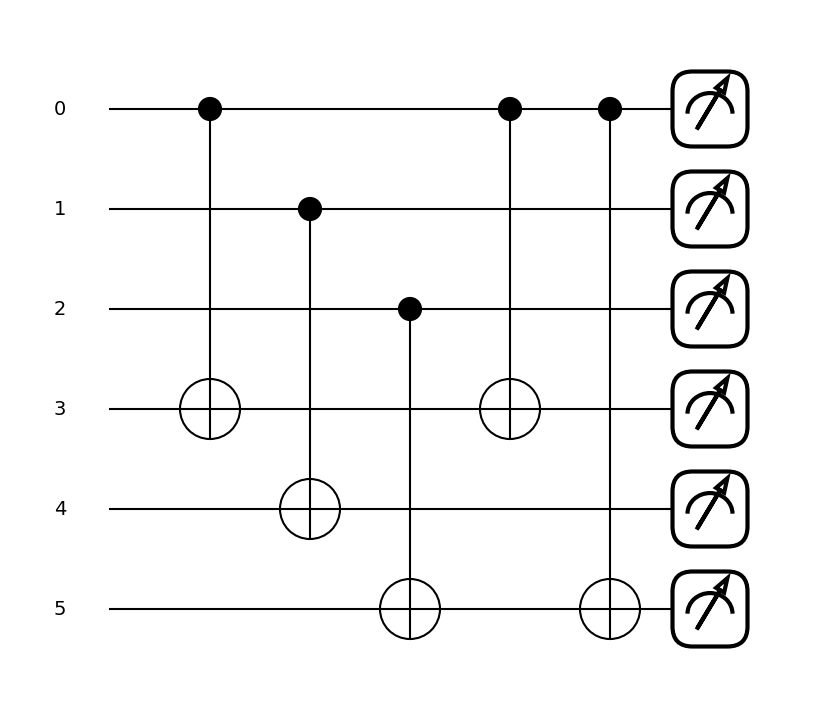

In [46]:
qml.draw_mpl(scratch_circuit)()

In [47]:
@qml.qnode(device)
def test_g_oracle(inits: str):
    for idx, init in enumerate(inits):
        if init == '1':
            qml.PauliX(wires=idx)
        
    g_oracle()
    
    return qml.sample()

In [48]:
validation_samples = []

for init in ['000', '001', '010', '011', '100', '101', '110', '111']:
    samples = test_g_oracle(init)
    validation_samples.append(samples)

Output the results:

In [49]:
print("x   => g(x)")
print("-----------")

for sample in validation_samples:
    x = ''.join(sample[:3].astype(str))
    gx = ''.join(sample[3:].astype(str))
    
    print(f"{x} => {gx}")

x   => g(x)
-----------
000 => 000
001 => 001
010 => 010
011 => 011
100 => 001
101 => 000
110 => 011
111 => 010


We find:

\begin{align*}
    s &= 000 \oplus 101 \\
      &= 001 \oplus 100 \\
      &= 010 \oplus 111 \\
      &= 011 \oplus 110 = 101
\end{align*}

which is the correct secret $s$.

Now it's time for the implementation of the algorithm. We will use $10$ shots to increase the probability of getting sufficient samples.

In [57]:
device = qml.device("default.qubit", wires=6, shots=10)

The implementation is basically a straightforward from the $f_1$ example:

In [58]:
@qml.qnode(device)
def simon_g():
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    
    g_oracle()
    
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    
    return qml.sample(wires=[0, 1, 2])

(<Figure size 1000x700 with 1 Axes>, <Axes:>)

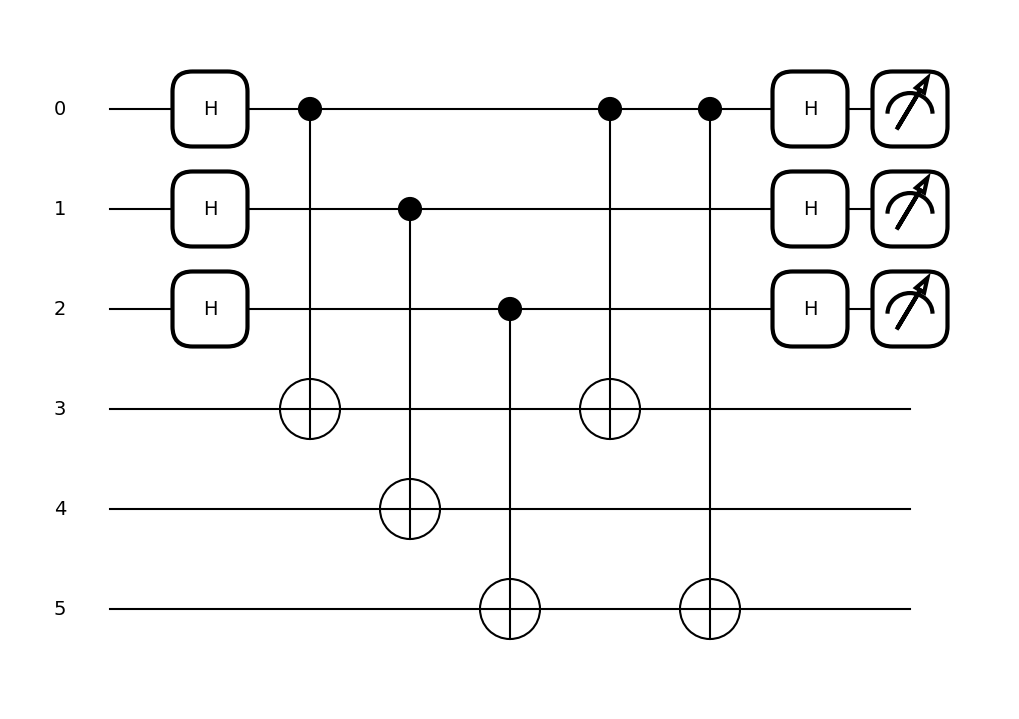

In [59]:
qml.draw_mpl(simon_g)()

In [60]:
samples = simon_g()
zs = np.unique(samples, axis=0)

Let's check if we got enough unique samples:

In [61]:
if zs.shape[0] < 3:
    print("Not enough samples, run again!")
else:
    print("We got enough samples, proceed.")

We got enough samples, proceed.


In [62]:
for idx, z in enumerate(zs[:3]):
    bitstring = ''.join(z.astype(int).astype(str))
    
    print(f"z_{idx+1} = {bitstring}")

z_1 = 000
z_2 = 010
z_3 = 101


Apart from the trivial solution $000$, the solution to this ois $s=101$, since:

\begin{align*}
    101 \cdot 000 &= 1\cdot 0 + 0\cdot 0 + 1\cdot 0 = 0\\
    101 \cdot 010 &= 1\cdot 0 + 0\cdot 1 + 1\cdot 0 = 0\\ 
    101 \cdot 101 &= 1\cdot 1 + 0\cdot 0 + 1\cdot 1 = 0
\end{align*}

Remeber that we are dealing with bits here, so all results are _modulo 2_. $s=101$ is where we started, so the algorithm worked correctly.

## References

* [1] _On the Power of Quantum Computation_, Daniel R. Simon, SIAM Journal on Computing (1997)
* [2] _Polynomial-Time Algorithms for Prime Factorization and Discrete Logarithms on a Quantum Computer_, Peter W. Shor, SIAM Journal on Computing (1997)